# Direct Collocation Integrator

Using collocation to integrate an ODE system.  Collocation is a high-order implicit integration scheme that works well in practice.

In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from casadi import MX, SX, DM, Function, Opti
import casadi as cas
from platform import python_version
from numpy.testing import assert_array_equal, assert_array_almost_equal

print(f"Casadi: {cas.__version__}")
print(f"Python: {python_version()}")

Casadi: 3.6.7
Python: 3.10.16


## The Collocation Problem

Consider the case of an autonomous system (no manipulated input)

Solve an initial value problem:

Get to $x(t_0 + \Delta t)$ from $x(t_0)$ given $ \dot{x}(t) = f(t, x)$.

The idea of collocation is to assume a polynomial $\Pi(t)$ as an approximation to $x(t)$ in the interval $[t_0, t_0 + \Delta t]$.

Need to find a set of coefficients of the polynomial that best match $ \dot{x}(t) = f(t, x)$.

$$\Pi(t; \text{coefficients})$$

<img src="images/collocation_method_2.png" width="50%">

## Exercise

Goal is to integrate the following time-dependent ODE

$$
\frac{d\left[\begin{array}{l}
x_1 \\
x_2
\end{array}\right]}{d t}=\left[\begin{array}{c}
\left(1-x_2^2\right) x_1-x_2+t \\
x_1
\end{array}\right]
$$

from $t_0 = 2$ to $t_f = 2.1$, with an initial value of $x_0 = \left[ \begin{array}{c} 1 \\ 0.5 \end{array} \right]$.

## 1. Implement CasADi Function of Righthand Side of ODE

Implement a CasADi Function $f$ that maps from time and state to the ODE’s right-hand side.

Create suitable MX symbols and use the following boilerplate:

```python
f = Function('f', list_of_input_symbols, list_of_output_expressions,
             list_of_input_labels, list_of_output_labels)
```

In [2]:
t = MX.sym('t')
x = MX.sym('x', 2)
x1, x2 = x[0], x[1]

# ODE righthand side
rhs = cas.vertcat(
    (1 - x2 ** 2) * x1 - x2 + t,
    x1
)
f = Function('f', [t, x], [rhs], ['t', 'x'], ['dxdt'])
f

Function(f:(t,x[2])->(dxdt[2]) MXFunction)

In [3]:
# Test
t0 = 2
dt = 0.1
tf = t0 + dt
x0 = cas.vertcat(1, 0.5)

assert_array_equal(np.array(f(t0, x0)).reshape(-1), [2.25, 1])

## 2. Integration Scheme

We will use a degree $d = 4$ legendre scheme for our collocation integrator. Make use of CasADi’s `collocation_points` helper function to obtain values for the dimensionless collocation points $\tau$. Use `help(collocation_points)` for help.

In [4]:
help(cas.collocation_points)

Help on function collocation_points in module casadi.casadi:

collocation_points(*args) -> 'std::vector< double,std::allocator< double > >'
      [INTERNAL] 
    
    ::
    
      collocation_points(int order, str scheme) -> [float]
    
    Obtain collocation points of specific order and scheme.
    
    Parameters:
    -----------
    
    order: 
    Which order (1 to 9 supported)
    
    scheme: 
    'radau' or 'legendre'
    
    Extra doc: https://github.com/casadi/casadi/wiki/L_1so
    
    Doc source: 
    https://github.com/casadi/casadi/blob/develop/casadi/core/integration_tools.hpp#L120
    
    Implementation: 
    https://github.com/casadi/casadi/blob/develop/casadi/core/integration_tools.cpp#L120-L122



In [5]:
d = 4
tau = DM(cas.collocation_points(d, 'legendre')).T
tau

DM([[0.0694318, 0.330009, 0.669991, 0.930568]])

## 3. Plot Interpolating Values

Locate and download the `LagrangePolynomialEval` function in the course material. Its mathematical prescription is given by:

$$
p\left(\left[X_1, \ldots, X_N\right],\left[Y_1, \ldots, Y_N\right], x\right)=\sum_{i=1}^N\left(\prod_{\substack{1 \leq j \leq N \\ j \neq i}} \frac{x-X_j}{X_i-X_j}\right) Y_i
$$

Plot the interpolating values for `X = [0 0.5 1], Y = [7 1 3]` and a range of x values between 0 and 1. Verify that the function performs an exact interpolation through each point `(Xi, Yi)`.


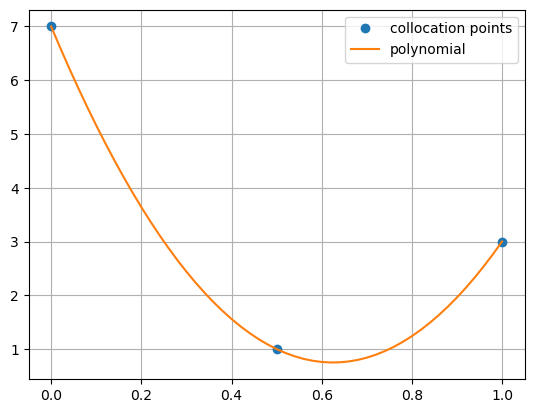

In [6]:
from lagrange_polynomial_eval import LagrangePolynomialEval

X = [0, 0.5, 1]
Y = [7, 1, 3]
x = np.linspace(0, 1, 51)

y_poly = LagrangePolynomialEval(X, Y, x)
plt.plot(X, Y, 'o', label='collocation points')
plt.plot(x, y_poly, '-', label='polynomial')
plt.grid()
plt.legend()
plt.show()

In [7]:
# Vectorized version for Numpy arrays only
from lagrange_polynomial_eval import lagrange_polynomial_eval_numeric

y_poly2 = lagrange_polynomial_eval_numeric(X, Y, x)
assert_array_almost_equal(y_poly2.reshape(-1), y_poly)

In [8]:
# Test with multi-dimensional Y
X = [0, 0.5, 1]
Y = [[7, 7], [1, 1], [3, 3]]
x = np.linspace(0, 1, 11)

y_poly2 = lagrange_polynomial_eval_numeric(X, Y, x)

assert_array_almost_equal(
    y_poly2, 
    [
        [7.  , 7.  ],
        [5.16, 5.16],
        [3.64, 3.64],
        [2.44, 2.44],
        [1.56, 1.56],
        [1.  , 1.  ],
        [0.76, 0.76],
        [0.84, 0.84],
        [1.24, 1.24],
        [1.96, 1.96],
        [3.  , 3.  ]
    ]
)

## 4. Scale the Collocation Points

Scale the dimensionless collocation points $\tau_i$ to obtain a collocation grid of the integration interval $[t_0, t_f]$.

In [9]:
t_coll = t0 + dt * tau
t_coll

DM([[2.00694, 2.033, 2.067, 2.09306]])

## 5. Construct $\Pi$ as a CasADi Function

Construct $\Pi$ as a CasADi Function with the following signature:

```text
Pi:(t,X0[2],Xc[2x4])->(Pi[2]) MXFunction
```

We desire that this Function interpolates exactly through $(t_0, X_0)$ and also through the points constructed by the collocation grid and the helper states $X_c$ defined on that grid.

You’ll need to introduce some MX symbols, and call `LagrangePolynomialEval` with three symbolic expressions as arguments. Verify that $\Pi$ evaluated at $t = t_0 + 0.05$, `X0` $= x_0$, and `Xc = [x0 + 1, x0 + 2, x0 + 4, x0 + 5]`, yields `[3.6501, 3.1501]`.


In [10]:
from lagrange_polynomial_eval import LagrangePolynomialEval

t0 = 2
dt = 0.1
nx = 2

d = 4

# Define collocation times
tau = DM(cas.collocation_points(d, 'legendre')).T
t_coll = t0 + dt * tau
T = cas.horzcat(t0, t_coll)

# Define collocation points
X0 = MX.sym("X0", nx)
Xc = MX.sym("Xc", nx, d)
X = cas.horzcat(X0, Xc)

# Polynomial function
t = MX.sym('t')

Pi_expr = LagrangePolynomialEval(T, X, t)

Pi = Function('Pi', [t, X0, Xc], [Pi_expr], ['t', 'X0', 'Xc'], ['Pi'])
Pi

Function(Pi:(t,X0[2],Xc[2x4])->(Pi[2]) MXFunction)

In [11]:
# Test
assert str(Pi) == "Pi:(t,X0[2],Xc[2x4])->(Pi[2]) MXFunction"

def evaluate_Pi(t0=2, dt=0.05, x0=(1, 0.5)):
    t = t0 + dt
    x0 = cas.vcat(x0)
    Xc = cas.horzcat(x0+1, x0+2, x0+4, x0+5)
    return Pi(t, x0, Xc)

assert_array_almost_equal(evaluate_Pi(), [[3.65013], [3.15013]], decimal=5)

## 6. Time Derivative of Pi

Construct a CasADi function of the time-derivative of the $\Pi$:

```text
dot_Pi:(t,X0[2],Xc[2x4])->(dPi[2]) MXFunction
```

Verify that it evaluates to `[61.1122; 61.1122]` for the same evaluation point.

In [12]:
dPidt_expr = cas.jacobian(Pi_expr, t)
dot_Pi = Function('dot_Pi', [t, X0, Xc], [dPidt_expr], ['t', 'X0', 'Xc'], ['dPidt'])
dot_Pi

Function(dot_Pi:(t,X0[2],Xc[2x4])->(dPidt[2]) MXFunction)

In [13]:
def evaluate_dot_Pi(t0=2, dt=0.05, x0=(1, 0.5)):
    t = t0 + dt
    x0 = cas.vcat(x0)
    Xc = cas.horzcat(x0+1, x0+2, x0+4, x0+5)
    return dot_Pi(t, x0, Xc)

assert_array_almost_equal(evaluate_dot_Pi(), [[61.1122], [61.1122]], decimal=4)

## 7. Create Expression for Collocation Residual

Create a 8-by-1 expression g that represent the collocation residual (polynomial derivative 
should match right-hand side) for our system on the integration interval. Verify that, for 
`X0`$=x0$, and `Xc=[x0+1 x0+2 x0+4 x0+5]`, this yields `[107.130;103.137;35.726;16.509;...]`.

Hint: To create a matrix expression out of individual parts formed in a for-loop, use the 
following idiom:

```python
g = []
for j in range(d):
    g.append( ... )
g = vcat(g)
```

In [14]:
t_coll

DM([[2.00694, 2.033, 2.067, 2.09306]])

In [15]:
X0 = MX.sym("X0", nx)
Xc = MX.sym("Xc", nx, d)

g = []
for j in range(d):
    g.append(dot_Pi(t_coll[j], X0, Xc) - f(t_coll[j], Xc[:, j]))
g = cas.vcat(g)

assert g.shape == (8, 1)


In [16]:
gf = cas.Function('gf', [X0, Xc], [g], ['X0', 'Xc'], ['g'])
gf

Function(gf:(X0[2],Xc[2x4])->(g[8]) MXFunction)

In [17]:
def evaluate_g(x0=(1, 0.5)):
    x0 = cas.vcat(x0)
    Xc = cas.horzcat(x0+1, x0+2, x0+4, x0+5)
    return gf(x0, Xc)

assert_array_almost_equal(
    evaluate_g(),
    [[107.130], [103.137], [35.726], [16.509], [187.686], [84.003], [108.022], [-76.884]],
    decimal=3
)

## 8. Use a Rootfinder to Find the Helper States $X_c$

Finally, use a rootfinder to find the values of helper states Xc. Use `X0` as a parameter (`p`) of the rootfinder. Verify that you have an equal number of unknowns and equations first. Note that the rootfinder expects a column vector of unknowns. You may need to flatten a matrix with `vec(mat)`.

Verify that your collocation integrator ends up at `xf = [1.226454824197, 0.6113162319035]`.

In [18]:
solver = cas.rootfinder('solver', 'newton', {'x': cas.vec(Xc), 'p': X0, 'g': g})

def evaluate_solver(t0=2, dt=0.1, x0=(1, 0.5)):
    x0 = cas.vcat(x0)
    res = solver(x0=cas.repmat(x0, d, 1), p=x0)
    Xc = res['x'].reshape((nx, d))
    tf = t0 + dt
    Y = Pi(tf, x0, Xc)
    return Y

Y_sol = evaluate_solver()

assert_array_almost_equal(Y_sol, [[1.226454824197], [0.6113162319035]], decimal=12)

## 9. Verify that the Result is Identical with CasADi’s Built-in Integrators

In [19]:
def evaluate_with_builtin_integrator(t0=2, dt=0.1, x0=(1, 0.5)):

    t = MX.sym('t')
    x = MX.sym('x', 2)
    x1, x2 = x[0], x[1]

    # ODE righthand side
    rhs = cas.vertcat(
        (1 - x2 ** 2) * x1 - x2 + t,
        x1
    )

    # Construct integrator
    ode = {'x': x, 't': t, 'ode': rhs}
    tf = t0 + dt
    options = {
        "number_of_finite_elements": 1,
        "interpolation_order": 4,
        "collocation_scheme": 'legendre'
    }
    intg = cas.integrator('intg', 'collocation', ode, t0, tf, options)

    # Solve initial value problem
    res = intg(x0=x0)

    return res["xf"]

xf_sol = evaluate_with_builtin_integrator()
print(xf_sol)
assert_array_almost_equal(xf_sol, [[1.226454824197], [0.6113162319035]], decimal=12)

[1.22645, 0.611316]
